<a href="https://colab.research.google.com/github/Charlotte-99/Y3Project/blob/main/Input_Pipeline_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building and Using a Custom Input Pipeline


## Setup
Section to import modules and mount Google drive folder.

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Navigate to project folder
os.chdir('/content/drive/My Drive/Project')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.colors import ListedColormap
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

## Formatting data
In this section we create arrays to contain our maps and labels. For this notebook we will just use the 100 CMB maps and 100 string maps we generated before.

We will use this to eventually create a dataset containing:


1.   50 CMB maps
2.   50 CMB + string maps (discontinuity maps)



In [3]:
# Load cmb cutouts and merge into one array
cmb = np.concatenate([np.load('cmb_map0_extracts.npy'),
                      np.load('cmb_map1_extracts.npy'),
                      np.load('cmb_map2_extracts.npy')])

# Load string cutouts and merge into one array
string = np.concatenate([np.load('map1n_allz_rtaapixlw_2048_1_extracts.npy'),
                        np.load('map1n_allz_rtaapixlw_2048_2_extracts.npy'),
                        np.load('map1n_allz_rtaapixlw_2048_3_extracts.npy')])

cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

We will shuffle these string and cmb arrays to create a good mix from the different cmb and string maps. We can see below that the cmb[0][0][0] element changes with each run of the cell.

We can then add a channel dimension to the string and cmb maps and introduce a labelling scheme where we use 0s and 1s. We will label the first 50 images 0 and the second half 1. The label will determine whether we add the discontinuities to the CMB map.

We will also shuffle the arrays above with the same seed. This is so that the dataset won't have 50 samples labelled '0' and 50 labelled '1' in that order. Instead, we want a mixture.

In [4]:
print(cmb[0][0][0])

# Shuffle images
np.random.shuffle(cmb)
np.random.shuffle(string)

print(cmb[0][0][0])

# Add channel dimension to string and cmb maps
X_string = string[..., np.newaxis]
X_cmb = cmb[..., np.newaxis]

# Introduce labels
y = np.concatenate([np.zeros(50), np.ones(50)])

print(X_string.shape)
print(X_cmb.shape)
print(y.shape)

# Shuffle with same seed
np.random.RandomState(7).shuffle(X_string)
np.random.RandomState(7).shuffle(X_cmb)
np.random.RandomState(7).shuffle(y)

4.219820402795449e-05
0.00013102179218549281
(100, 200, 200, 1)
(100, 200, 200, 1)
(100,)


## Building a Pipeline and CNN



Now we will build a tensorflow dataset using tensor slices. This dataset will have three elements per sample: a string map, a CMB map and a label.

If a sample has the label 0, it will not undergo a 'string' augmentation but will undergo random rotations. If a sample has the label 1, it will undergo a string augmentation.

In [5]:
# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((X_string, X_cmb,y))

We will define a function that does the following:


1.   The function takes three inputs: a string map, a CMB map and a label.
2.   It will perform one of the two augmentations, depending on the label: a random rotation, or a random string augmentation (see code below)
3. It will output the augmented map and the original label.



In [6]:
def selective_string_maps(string_map, cmb_map, label):
  # label value
  N = np.int(label)

  # Transformation: rotate CMB map
  # Output: rotated CMB map and original label
  def rotation():
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    return cmb_rot, label

  # Transformation: introduce discontinuities to CMB map
  # Output: discontinuity map and original label
  def add_string():
    alpha = 5e-6
    string_rot = tf.image.rot90(string_map, tf.random.uniform(shape=[], minval=0,
                                maxval=4, dtype=tf.int32))
    string_scaled = tf.multiply(string_rot, alpha)
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                            maxval=4, dtype=tf.int32))
    aug_cmb = tf.add(cmb_rot, string_scaled)
    return aug_cmb, label

  return tf.cond(N == 0, true_fn=rotation, false_fn=add_string)

Now let's test this out. We'll select the first four images from the dataset and see what happens.

Running the second cell below several times will apply different transformations each time.

In [7]:
# Need to apply the map method in a separate cell for this case
dataset = dataset.map(selective_string_maps)

0
0
1
1


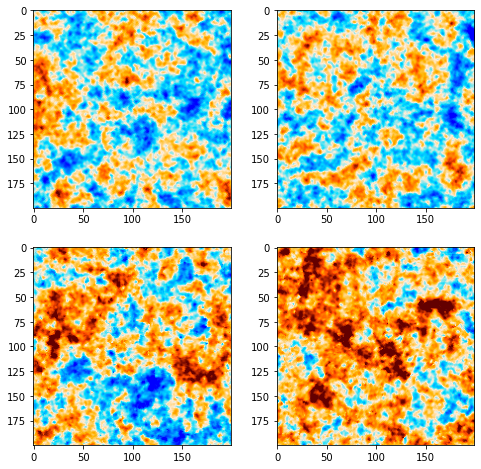

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
n = 0
for map, lab in dataset.take(4):
  axes.flat[n].imshow(np.reshape(map, (200, 200)), cmap=cmap, vmin=-300e-6, vmax=300e-6)
  print(int(lab))
  n += 1

Great! Now we can use this for our CNN. 

Note that half of our string maps will end up being unused in this case, but since we're just experimenting it doesn't matter too much. When we use large datasets, we can just set the string maps for the samples labelled 0 to zero arrays.

## Using the pipeline in a CNN
In this section we will use what we've done above in a CNN model.

Here, we define our model.

In [9]:
# Build model
def build_model():
  model = Sequential([Conv2D(32, 3, activation='relu'),
                      Conv2D(32, 3, activation='relu'),
                      MaxPooling2D(2),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(2, activation='softmax')
                      ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  return model

Then we define a transformation function that performs batch normalisation. This is because we will be inputting batches to our model.

In [10]:
def batch_normalization(map, label):
  epsilon = 0.0001
  mean, variance = tf.nn.moments(map, axes=[0])
  map_normalized = (map - mean)/(variance + epsilon)
  return map_normalized, label  

In the cell below, we redefine our dataset and introduce four new methods: a shuffle method which will shuffle our dataset with each epoch, a batching method which will create batches from our dataset, another mapping function for batch normalisation (as defined above) and finally a prefetch method which means that while our CNN is training on one element, it will begin 'fetching' the next element at the same time. 

We will also run our CNN using our dataset.

In [11]:
# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((X_string, X_cmb, y))

dataset = dataset.map(selective_string_maps)
dataset = dataset.shuffle(200)
dataset = dataset.batch(16)
dataset = dataset.map(batch_normalization)
dataset = dataset.prefetch(1)

model = build_model()

history = model.fit(dataset, epochs=20, verbose=1)
print(model.summary())

Epoch 1/20
7/7 [==============================] - 31s 119ms/step - loss: 19.3270 - accuracy: 0.5349
Epoch 2/20
7/7 [==============================] - 1s 76ms/step - loss: 2.8523 - accuracy: 0.5320
Epoch 3/20
7/7 [==============================] - 1s 76ms/step - loss: 1.1043 - accuracy: 0.5106
Epoch 4/20
7/7 [==============================] - 1s 74ms/step - loss: 0.6259 - accuracy: 0.7239
Epoch 5/20
7/7 [==============================] - 1s 74ms/step - loss: 0.6491 - accuracy: 0.6171
Epoch 6/20
7/7 [==============================] - 1s 73ms/step - loss: 0.5731 - accuracy: 0.8009
Epoch 7/20
7/7 [==============================] - 1s 77ms/step - loss: 0.5306 - accuracy: 0.7739
Epoch 8/20
7/7 [==============================] - 1s 77ms/step - loss: 0.5340 - accuracy: 0.7303
Epoch 9/20
7/7 [==============================] - 1s 77ms/step - loss: 0.3848 - accuracy: 0.8686
Epoch 10/20
7/7 [==============================] - 1s 74ms/step - loss: 0.3054 - accuracy: 0.9020
Epoch 11/20
7/7 [=========